# Benchmark code for 3d correlation function

This code requires cluster_toolkit.

In [1]:
import numpy as np
import pyccl as ccl
import cluster_toolkit
#cluster toolkit package is available at http://cluster-toolkit.readthedocs.io/en/latest/source/installation.html
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
bench_ind = 3

if bench_ind == 1:
    cosmo = ccl.Cosmology(
        Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.8, 
        n_s=0.96, w0=-1.0, wa=0.0, Omega_g=0,
        transfer_function='bbks')
elif bench_ind == 2:
    cosmo = ccl.Cosmology(
        Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.8, 
        n_s=0.96, w0=-0.9, wa=0.0, Omega_g=0,
        transfer_function='bbks')        
elif bench_ind == 3:
    cosmo = ccl.Cosmology(
        Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.8, 
        n_s=0.96, w0=-0.9, wa=0.1, Omega_g=0,
        transfer_function='bbks')

In [47]:
k = np.logspace(np.log10(5.e-5), 3., 730000) # Wavenumber
h = 0.7

In [48]:
# CCL power spectrum
pk = []
for n in range(6):
    pk.append(ccl.nonlin_matter_power(cosmo, k, 1./(n+1)))

In [49]:
# calculate CCL xi and benchmark xi for r = 0.1 - 100 with 40 bins
nr1 = 40
r1 = np.logspace(-1, 2, nr1)

xi1 = []
for n in range(6):
    xi1.append(ccl.correlation_3d(cosmo, 1./(n+1), r1))

xi_toolkit1 = []
for n in range(6):
    xi_toolkit1.append(cluster_toolkit.xi.xi_mm_at_r(h*r1, k/h, pk[n]*h*h*h, exact=True))    
        
# calculate CCL xi and benchmark xi for r = 50 - 250 with 100 bins to check agreement in teh BAO peak region
nr2 = 100
r2 = np.logspace(np.log10(50), np.log10(250), nr2)

xi2 = []
for n in range(6):
    xi2.append(ccl.correlation_3d(cosmo, 1./(n+1), r2))

xi_toolkit2 = []
for n in range(6):
    xi_toolkit2.append(cluster_toolkit.xi.xi_mm_at_r(h*r2, k/h, pk[n]*h*h*h, exact=True))

In [50]:
# write benchmark xi to file
with open('model%d_xi.txt' % bench_ind,'w') as f:

    f.write('#  [0] r (Mpc; comoving), [1] xi(r,z=0.0), [2] xi(r,z=1.0), [3] xi(r,z=2.0), [4] xi(r,z=3.0), [5] xi(r,z=4.0), [6] xi(r,z=5.0)' + '\n')

    for i in range(140):
        col = []
        s = ''
        if i < 40:
            col.append("{:.18e}".format(r1[i]).ljust(25))
            for n in range(6):
                col.append("{:.18e}".format(xi_toolkit1[n][i]).ljust(25))
        else:
            col.append("{:.18e}".format(r2[i-40]).ljust(25))
            for n in range(6):
                col.append("{:.18e}".format(xi_toolkit2[n][i-40]).ljust(25))
        s = ' '.join(col)
        f.write(s + '\n')

In [31]:
# print some values
n = 0 # redshift    
print("r                        xi(CCL)                   xi(benchmark)            Delta(r^2 xi)       Delta xi / xi_benchmark")
for i in range(140):
    col = []
    s = ''
    if i < 40:
        col.append("{:.5e}".format(r1[i]).ljust(25))
        col.append("{:.5e}".format(xi1[n][i]).ljust(25))
        col.append("{:.5e}".format(xi_toolkit1[n][i]).ljust(25))
        err = r1[i]*r1[i]*(xi1[n][i]-xi_toolkit1[n][i])
        col.append("{:.5e}".format(err).ljust(25))
        rel_diff = (xi1[n][i]-xi_toolkit1[n][i])/xi_toolkit1[n][i]
        col.append("{:.5e}".format(rel_diff).ljust(25))
    #s = col[0] + col[1] + col[2] + col[3] + col[4]
    else:
        col.append("{:.5e}".format(r2[i-40]).ljust(25))
        col.append("{:.5e}".format(xi2[n][i-40]).ljust(25))
        col.append("{:.5e}".format(xi_toolkit2[n][i-40]).ljust(25))
        err = r2[i-40]*r2[i-40]*(xi2[n][i-40]-xi_toolkit2[n][i-40])
        col.append("{:.5e}".format(err).ljust(25))
        rel_diff = (xi2[n][i-40]-xi_toolkit2[n][i-40])/xi_toolkit2[n][i-40]
        col.append("{:.5e}".format(rel_diff).ljust(25)) 
    s = col[0] + col[1] + col[2] + col[3] + col[4]
        
    print(s)

r                        xi(CCL)                   xi(benchmark)            Delta(r^2 xi)       Delta xi / xi_benchmark
1.00000e-01              9.13885e+02              9.16199e+02              -2.31471e-02             -2.52643e-03             
1.19378e-01              7.68389e+02              7.69716e+02              -1.89134e-02             -1.72422e-03             
1.42510e-01              6.44119e+02              6.43962e+02              3.18136e-03              2.43254e-04              
1.70125e-01              5.34180e+02              5.34738e+02              -1.61577e-02             -1.04400e-03             
2.03092e-01              4.41434e+02              4.41346e+02              3.65583e-03              2.00827e-04              
2.42446e-01              3.61355e+02              3.60953e+02              2.35976e-02              1.11221e-03              
2.89427e-01              2.92533e+02              2.92692e+02              -1.33039e-02             -5.42614e-04            

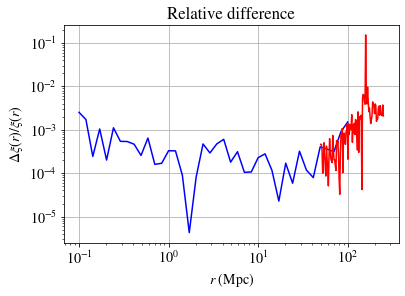

frac diff for r = 0.1-100:  0.002526427174667445
frac diff for r = 50-250:  0.15306941576688715


In [32]:
# Plot relative difference
frac_diff1 = []
frac_diff2 = []
abs_diff1 = []    
abs_diff2 = []

for i in range(nr1):
    frac_diff1.append(np.abs(xi1[n][i]/xi_toolkit1[n][i] - 1.))
    abs_diff1.append(np.abs(r1[i]*r1[i]*(xi1[n][i]-xi_toolkit1[n][i])))
    #print r1[i], xi_toolkit1[n][i], xi1[n][i], r1[i]*r1[i]*(xi1[n][i]-xi_toolkit1[n][i])
    
for i in range(nr2):
    frac_diff2.append(np.abs(1-xi2[n][i]/xi_toolkit2[n][i]))
    abs_diff2.append(np.abs(r2[i]*r2[i]*(xi2[n][i]-xi_toolkit2[n][i])))

# esthetic definitions for the plots
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 14

plt.plot(r1, frac_diff1, 'b-')
plt.plot(r2, frac_diff2, 'r-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$ (Mpc)')
plt.ylabel(r'$\Delta \xi(r) / \xi(r)$')
plt.grid(which='major')
plt.title('Relative difference') 
plt.savefig('benchmark_rel.pdf',bbox_inches = 'tight')
plt.show()
#print frac_diff1
print("frac diff for r = 0.1-100: ", np.amax(frac_diff1))
print("frac diff for r = 50-250: ", np.amax(frac_diff2))

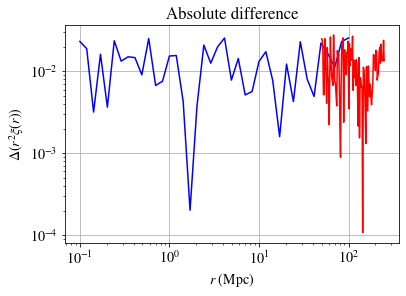

max diff for r = 0.1-100:  0.02554546783902975
max diff for r = 50-250:  0.027782293661027104
average Delta(r^2 xi) for r=140-150 Mpc: 0.006977835181869886


In [33]:
# plot absolute difference in r^2 xi(r)
plt.plot(r1, abs_diff1, 'b-')
plt.plot(r2, abs_diff2, 'r-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$ (Mpc)')
plt.ylabel(r'$\Delta (r^2 \xi(r)) $')
plt.grid(which='minor')
plt.title('Absolute difference') 
plt.grid(which='both')
plt.savefig('benchmark_abs.pdf',bbox_inches = 'tight')
plt.show()
#print abs_diff
print("max diff for r = 0.1-100: ", np.amax(abs_diff1))
print("max diff for r = 50-250: ", np.amax(abs_diff2))


# find and print the average of Delta(r^2 xi) in the BAO peak region
max_value = 0
max_value_index = 0
avg_value = 0
for i in range(63,68):
    #print i, r2[i], abs_diff2[i]
    avg_value = avg_value + abs_diff2[i]
avg_value = avg_value / 5.
print("average Delta(r^2 xi) for r=140-150 Mpc:", avg_value)

In [34]:
for i in range(nr1):
    col = []
    s = ''
    col.append("{:.18e}".format(r1[i]).ljust(25))
    col.append("{:.18e}".format(frac_diff1[i]).ljust(25))
    col.append("{:.18e}".format(abs_diff1[i]).ljust(25))
    s = col[0] + col[1] + col[2]  
    #print(s)

In [35]:
for i in range(nr2):
    col = []
    s = ''
    col.append("{:.18e}".format(r2[i]).ljust(25))
    col.append("{:.18e}".format(frac_diff2[i]).ljust(25))
    col.append("{:.18e}".format(abs_diff2[i]).ljust(25))
    s = col[0] + col[1] + col[2]  
    #print(s)